# Small conductance based network

In this project, we aim at simulating a small (two-neuron) network formed by identical conductance-
based neuron models, with the following structure:
- Neuron 1 receives a Poisson input at ν Hz through synapses modulated by an α function.
- Neuron 1 excites Neuron 2 through a graded synapsis.
- Neuron 2 inhibits Neuron 1 through a graded synapsis.

In the last part of the project, we will study the effect of plasticity (facilitation and depression).



**1-Simulate an input Poisson train for 1 second with rate $ν = 50Hz$**. 

For the homogeneous Poisson process we have $P\,[\text{ 1 spike during } \delta t]=r\delta t$ where $r$ is the input rate. This equation can be used to generate a Poisson  spike train $\{t_j\}_{j=1}^{n_{spk}}$ by first subdividing time into short intervals, each of duration $\delta t$. Then, generate a sequence of random numbers $x[i]$, uniformly distributed between 0 and 1. For each $\delta t$-interval, if $x[i] ≤ r∆t$, generate a spike. Otherwise, no spike is generated. This procedure is appropriate only when $\delta t$ is very small, i.e, only when $r\delta t$ << 1. Typically, ${\delta t}$ = 0.1 msec should suffice. 

For more information, see these notes by David Heeger (NYU).

In [2]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

Simple run

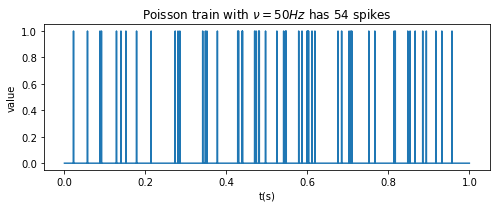

In [3]:
dt = 0.0001 # dt = 0.1msec
t = np.arange(0.0, 1.0, dt)
rate = 50

spikes = np.random.rand(len(t)) < rate*dt #Determine list of times of spikes
spikes = spikes.astype(int)

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(t, spikes)
ax.set(title=f"Poisson train with $ν = 50Hz$ has {np.sum(spikes)} spikes",
       xlabel="t(s)",
       ylabel="value")
fig.tight_layout()
fig.show()

Number of spikes histogram

In [4]:
dt = 0.0001 # dt = 0.1msec
t = np.arange(0.0, 1.0, dt)
rate = 50

n_runs = 10000
results = np.zeros(n_runs)
for i in range(n_runs):
    spikes = np.random.rand(len(t)) < rate*dt #Determine list of times of spikes
    spikes = spikes.astype(int)
    results[i] = np.sum(spikes)

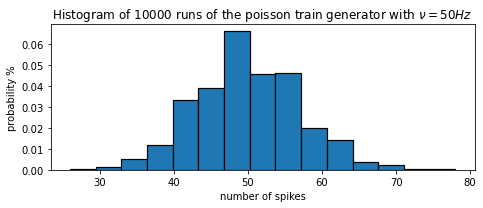

In [5]:
fig, ax = plt.subplots(figsize=(7,3))
ax.hist(results,15,density=True,edgecolor='black', linewidth=1.2)
ax.set(title=f"Histogram of {n_runs} runs of the poisson train generator with $ν = 50Hz$",
       xlabel="number of spikes",
       ylabel="probability %")
fig.tight_layout()
fig.show()

Time between spikes histogram

In [6]:
dt = 0.0001 # dt = 0.1 msec
t = np.arange(0.0, 1.0, dt)
rate = 50

n_runs = 100
intervals = []
for i in range(n_runs):
    spikes = np.random.rand(len(t)) < rate*dt #Determine list of times of spikes
    index = np.where(spikes)[0]
    intervals.append(index[1:]-index[:-1])
    
intervals = np.concatenate(intervals).ravel()

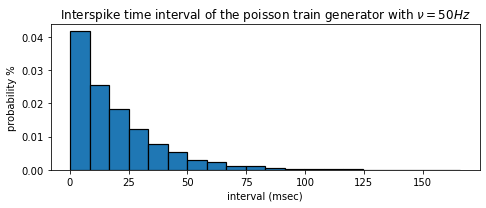

In [7]:
fig, ax = plt.subplots(figsize=(7,3))
ax.hist(intervals*0.1,20,density=True,edgecolor='black', linewidth=1.2)
ax.set(title=f"Interspike time interval of the poisson train generator with $ν = 50Hz$",
       xlabel="interval (msec)",
       ylabel="probability %")
fig.tight_layout()
fig.show()

In [7]:
def spike_train(d, rate, dt):
    """ Generates Poisson delta train
    Params:
    d (int): duration in milliseconds of the train
    rate (int): how many firings per second (Hz)
    dt (float): time differential used in the simulation
    Returns:
    result (np.array) with the indexes of the spikes
    """
    # As the standard dt is 1ms and this is not enough for this method to
    # give accurate results I add a reduction factor to spike generation
    n = int(d/dt)
    spikes = np.random.rand(n) < rate/1000*dt # Here we divide by 1000 bc milliseconds
    index = np.where(spikes)[0]
    return index*dt

**2-Study of the post-synaptic potentials induced by the Poisson train.**

From the spike train obtained in (1), generate a synaptic input $g_{syn}(t) = \hat{g}\sum_j\alpha(t-t_j)H(t-t_j)$ where $\alpha (t) = 1/\tau_{s}^{2}t\text{exp}(-t/\tau_{s})$ and $H$ is the Heaviside function. Inject it into the system (you can try to inject the first only):

$$CV = I - g_L(V-E_L)-g_{Na}m_{\infty}(V)(V-E_{Na})-g_Kn(V-E_K)+g_{syn}(t)(V-E_{syn})$$
$$\tau_nn = n_{\infty}(V)-n$$

with
$$m_{\infty}(V) = 1./(1.+exp(-(V-V_{max,m})/k_m))$$
and
$$n_{\infty}(V) = 1./(1.+exp(-(V-V_{max,n})/k_n))$$

In [21]:
# global model variables
ena, ek, el, esyn = 60, -90, -80, 0
gna, gk, gl = 20, 10, 8 
C, I = 1, 0
vmaxm, vmaxn = -20, -25
km, kn = 15, 5
taun, taus = 1, 5 

Synaptic excitation function

In [10]:
def alfa(t):
    return 1/taus**2*t*np.e**(-t/taus)
def step(t):
    return 1 if t > 0 else 0
def gsyn(t, train):
    result = 0
    for it in train:
        result += alfa(t-it)*step(t-it)
    return result

Synaptic excitation run with simple input

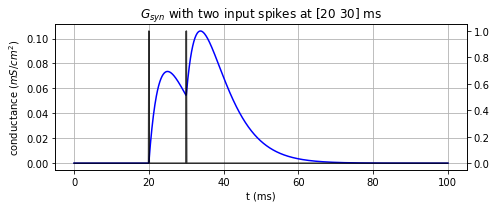

In [11]:
results = []
spikes = np.array([20,30])
time_span = np.linspace(0,100,1000)
for t in np.linspace(0,100,1000):
    results.append(gsyn(t, spikes))

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(time_span, results, c='b')

ax2 = ax.twinx()
spike_p = np.zeros(time_span.shape[0])
spike_p[spikes*10] += 1
ax2.plot(time_span, spike_p,c='k',alpha=0.8,)

ax.set(title="$G_{syn}$ "+f"with two input spikes at {spikes} ms",
       xlabel="t (ms)",
       ylabel="conductance ($mS/cm^2$)")
ax.grid()

fig.tight_layout()
fig.show()

Synaptic excitation run with complex input

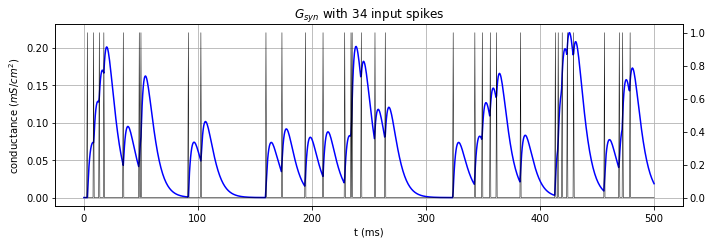

In [12]:
dt=0.1 # 0.1ms
d = 500
time_span = np.linspace(0,500,1000)
spikes = spike_train(d, 50, dt)
results = []
for t in time_span:
    results.append(gsyn(t, spikes))

fig, ax = plt.subplots(figsize=(10,3.5))
ax.plot(time_span, results,lw=1.5, c='b')

ax2 = ax.twinx()
spike_p = np.zeros(1000)
spike_p[np.rint(spikes*2).astype(int)] += 1   # Multiply by quotient of d/n_samples
ax2.plot(time_span, spike_p, c='k',alpha=1, lw=0.5)

ax.set(title="$G_{syn}$ "+f"with {spikes.shape[0]} input spikes",
       xlabel="t (ms)",
       ylabel="conductance ($mS/cm^2$)")
ax.grid()

fig.tight_layout()
fig.show()

Neuron equations

In [13]:
def minf(V):
    return 1/(1+np.e**(-(V-vmaxm)/km))
def ninf(V):
    return 1/(1+np.e**(-(V-vmaxn)/kn))

def neuron_wo_syn(X, t, I=0): 
    
    V = X[0]
    n = X[1]
    
    dVdt = (I - gl*(V-el) - gna*minf(V)*(V-ena) - gk*n*(V-ek))/C
    dndt = (ninf(V) - n)/taun
    
    return [dVdt, dndt]

Temporal run without synapsis excitation

In [13]:
from scipy.integrate import odeint
from functools import partial

In [15]:
def get_displacement(param, dmax=50,time_span=np.linspace(0,200, 1000), number=3):
    # We start from the resting point...
    ic = odeint(partial(neuron_wo_syn, **param),
                                                      y0=[0,0],
                                                      t= np.linspace(0,999, 1000))[-1]
    # and do some displacement of the potential. 
    traj = [] 
    for displacement in np.linspace(0,dmax, number):
        traj.append(odeint(partial(neuron_wo_syn, **param),
                                                      y0=ic+np.array([displacement,0]),
                                                      t=time_span))
    return traj

In [16]:
# Simulation params
time_span = np.linspace(0.0, 10.0, 1000)
Iapp = [{"I": 0},{"I": 30},{"I": 300}]

# Do the numerical integration.
trajectories = {} # We store the trajectories in a dictionnary, it is easier to recover them. 
for i,param in enumerate(Iapp):
    trajectories[i] = get_displacement(param, time_span=time_span, dmax=50,  number=3)

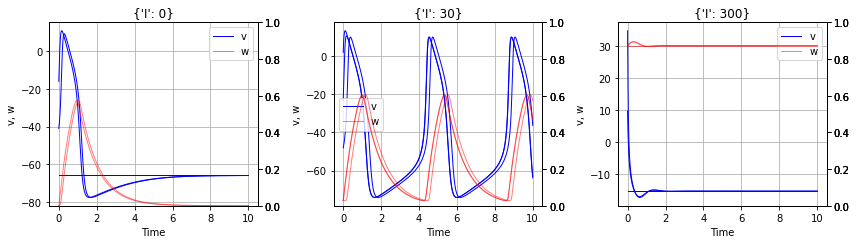

In [17]:
fig, ax = plt.subplots(1, len(Iapp), figsize=(4*len(Iapp),3.5))
for i,param in enumerate(Iapp):
        ax[i].set(xlabel='Time', ylabel='v, w',
                     title='{}'.format(param))
        for j in range(len(trajectories[i])):
            v = ax[i].plot(time_span,trajectories[i][j][:,0], color='b', lw=1)
            ax2 = ax[i].twinx()
            w = ax2.plot(time_span,trajectories[i][j][:,1], color='r', lw=1, alpha=0.5)
            ax2.set(ylim=(0,1))
        ax[i].legend([v[0],w[0]],['v','w'])
        ax[i].grid(True)
plt.tight_layout()

In [18]:
#TODO: ADD ISOCLINES, FLOW AND PHASE PLOT FOR THE THREE SCENARIOS

F-I curve no synaptical excitation

In [20]:
from collections import Counter
import os.path

def count_peaks(temporal_series, thr):
    # List of values
    values = temporal_series>-thr
    values = values.astype('int')
    # Computes the crossing 1: ascendent -1: descendent
    difference = values[1:]-values[:-1]
    # Count the number of 1 (ascendent crossings)
    peaks = Counter(difference)[1]
    
    return peaks

In [40]:
if not os.path.isfile('./data/frequency.npy'): 
    d, n = 500, 1000
    t = np.linspace(0.0, d, n)
    s0=[-66, 0]

    Iapps = np.arange(-10,180,1)

    freq_store = np.zeros(Iapps.shape[0])

    for ix,I in enumerate(Iapps):
        run = odeint(neuron_wo_syn, s0, t, args=(I,))
        peaks = count_peaks(run[:,0], 0)
        freq = peaks/d*1000
        freq_store[ix] = freq

    np.save('./data/frequency.npy',freq_store)
else:
    freq_store = np.load('./data/frequency.npy')

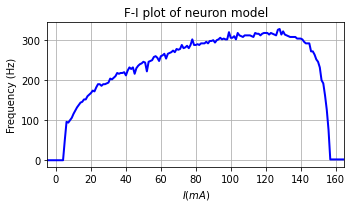

In [41]:
fig, ax = plt.subplots(figsize=(5,3))

ax.plot(Iapps, freq_store, lw=2.0, c='b')

ax.set(title="F-I plot of neuron model",
       xlabel="$I (mA)$",
       ylabel="Frequency (Hz)",
       xlim=(-5,165))
ax.grid()

fig.tight_layout()
fig.show()

**Temporal run with synaptical excitation**

In [24]:
# FAILED ATTEMPT NUMBER 1 AT SPEEDING THINGS UP:
# COMPUTE A TEMPORAL RUN AND PASS IT AS PARAMETER TO ODEINT
# IT WORKS BUT ONLY IF N=10*D OR (THE SAME) DT=0.1

def compute_syn_current(spikes, d, n):
    """ Computes temporal run and mean value
    Params:
        spikes ([float]): list with the time index of the spikes
        d (int): time duration in ms
        n (int): number of time_samples
    Returns:
        run ([float]): temporal run for the synaptic excitation with length n 
        mean_current: returns the mean value of the current
    """
    # Create synaptic excitation
    time_span = np.linspace(0, d, n)
    run = np.zeros(n)
    
    for it, t in enumerate(time_span):
        run[it] = (gsyn(t, spikes))
    
    return run, run.mean()


def neuron(X, t, param): 
    
    V = X[0]
    n = X[1]
    
    dVdt = (I - gl*(V-el) - gna*minf(V)*(V-ena) - gk*n*(V-ek) - 2*param[int(t*10)-2]*(V-esyn))/C
    dndt = (ninf(V) - n)/taun
    
    return [dVdt, dndt]

In [25]:
# FAILED ATTEMPT NUMBER 2 AT SPEEDING THINGS UP:
# CREATE A GENERATOR FUNCTION THAT RETURNS THE TEMPORAL RUN VALUE
# IT DOESN'T WORK BC ODEINT TAKES NON-CONSTANT DTs

def compute_syn_current(spikes, d, n):
    """ Creates generator function for the synaptic excitation
    Params:
        spikes ([float]): list with the time index of the spikes
        d (int): time duration in ms
        n (int): number of time_samples
    Returns:
        generator (func()): generator function for the synaptic excitation 
        mean_current: returns the mean value of the current
    """
    # Create synaptic excitation
    time_span = np.linspace(0, d, n)
    run = np.zeros(n)
    
    for it, t in enumerate(time_span):
        run[it] = (gsyn(t, spikes))
    
    def gen(run, n):
        i = 0
        while i<n:
            yield run[i]
            i += 1
    
    return run, run.mean()

def neuron(X, t, param): 
    
    V = X[0]
    n = X[1]
    
    dVdt = (I - gl*(V-el) - gna*minf(V)*(V-ena) - gk*n*(V-ek) - 2*param[int(t*10)-2]*(V-esyn))/C
    dndt = (ninf(V) - n)/taun
    
    return [dVdt, dndt]

How to speed up gsyn?

In [26]:
t = np.linspace(0,100,100)
run = alfa(t)
print(f"At t=25ms it only is {run[25]}")

At t=25ms it only is 0.006470805279250838


We only use spikes in a reduced time range -Xms and 0ms

In [42]:
def opt_gsyn(t, train):
    result = 0
    reduced_train = train[(train > (t-40)) & (train < t)]
    for it in reduced_train:
        result += alfa(t-it)*step(t-it)
    return result

In [46]:
d, n = 300, 3000
time_span = np.linspace(0.0, d, n)
train = spike_train(d, 50, d/n)

run1 = np.zeros(n)
run2 = np.zeros(n)

for it, t in enumerate(time_span):
    run1[it] = gsyn(t, train)
    run2[it] = opt_gsyn(t, train)

Text(0.5, 1.0, 'They look quite similar to me')

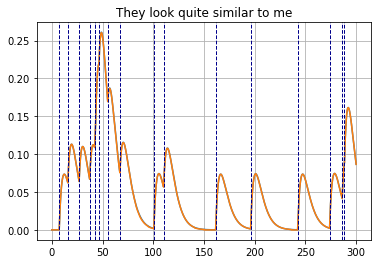

In [47]:
plt.plot(time_span, run1)
plt.plot(time_span, run2)
plt.grid()

for t in train:
    plt.axvline(x=t, color='darkblue', linestyle='dashed', linewidth=1, label='spike')

plt.title("They look quite similar to me")

In [27]:
#TODO: Compute RMSE per different X values

In [277]:
# ATTEMPT N. 3 AND SUCCESFUL ATTEMPT TO THE NEURON SIMULATION
# WE PASS THE SPIKES TEMPORAL INDEXES AND COMPUTE THE RESPONSE FOR THE T VALUE
# SLOW WHEN WE HAVE A HIGH NUMBER OF SPIKES. CAN BE SPED UP TRIMMING THE SPIKES WE CONSIDER FOR A GIVEN T

def compute_syn_current(spikes, d, n):
    """ Returns the mean current value
    """
    # Create synaptic excitation
    time_span = np.linspace(0, d, n)
    run = np.zeros(n)
    
    for it, t in enumerate(time_span):
        run[it] = (gsyn(t, spikes))
    
    return run.mean()

def neuron(X, t, spikes): 
    """ WRITE DOC """
    V, n = X
    
    dVdt = (0 - gl*(V-el) - gna*minf(V)*(V-ena) - gk*n*(V-ek) - 3*opt_gsyn(t, spikes)*(V-esyn))/C
    dndt = (ninf(V) - n)/taun
    
    return [dVdt, dndt]

In [278]:
d, n = 500, 4000
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

mean = compute_syn_current(spikes, d, n)

run, obs = odeint(partial(neuron, **{"spikes": spikes}), y0=[-66,0], t=time_span, full_output=1)

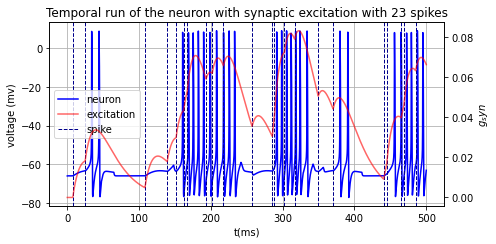

In [280]:
fig, ax = plt.subplots(1, figsize=(7,3.5))

# Plot neuron response
l1, = ax.plot(time_span, run[:,0], c='b', label='neuron')

# Plot spike lines
for t in spikes:
    l3 = ax.axvline(x=t, color='darkblue', linestyle='dashed', linewidth=1, label='spike')

# Create synaptic excitation
results = np.zeros(time_span.shape[0])
for it, t in enumerate(time_span):
    results[it] = (gsyn(t, spikes))

# And plot it in secondary axes
ax2 = ax.twinx()
ax2.set(ylabel="$g_syn$")
l2, = ax2.plot(time_span,results, c='r', alpha=0.6, label='excitation')

ax.set(title=f"Temporal run of the neuron with synaptic excitation with {spikes.shape[0]} spikes",
   xlabel="t(ms)",
   ylabel="voltage (mv)",
   )
ax.grid()

lines = [l1,l2,l3]
ax.legend(lines, [l.get_label() for l in lines])


fig.tight_layout()
fig.show()

F-I plot with average synaptic input current

In [287]:
d, n= 500, 1000
time_span = np.linspace(0.0, d, n)

rates = np.linspace(0,1500,60)

currents = np.zeros(rates.shape[0])
freqs = np.zeros(rates.shape[0])
if not os.path.isfile('./data/frequency_syn.npy'): 
    for i,r in enumerate(rates):
        if not i%10: print(f"Now computing rate: {r:.2f} {i}/{rates.shape[0]}")
        spikes = spike_train(1000, r, d/n)

        mean = compute_syn_current(spikes, d, n)

        currents[i] = mean

        run = odeint(partial(neuron, **{"spikes":spikes}), y0=[-66,0], t=time_span)


        peaks = count_peaks(run[:,0], 0)
        freqs[i] = peaks/d*1000
    np.save('./data/frequency_syn.npy', freqs)
else:
    freqs = np.load('./data/frequency_syn.npy')

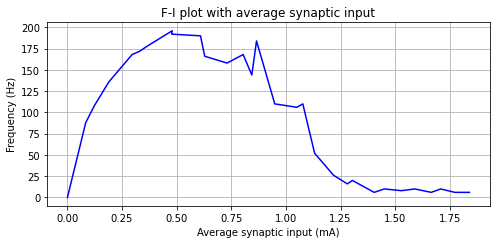

In [286]:
fig, ax = plt.subplots(1, figsize=(7,3.5))

ax.plot(currents, freqs, c='b') 

ax.set(title=f"F-I plot with average synaptic input",
   xlabel="Average synaptic input (mA)",
   ylabel="Frequency (Hz)",
   )
ax.grid()


fig.tight_layout()
fig.show()

**3-Study two neuron dynamics**


In [14]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from functools import partial

In [25]:
# global single cell parameters
ena, ek, el, esyn = 60, -90, -80, 0
gna, gk, gl = 20, 10, 8 
C, I = 1, 0
vmaxm, vmaxn = -20, -25
km, kn = 15, 5
taun, taus = 1, 5 

# global two cell parameters
vt, vs = 2, 5
As = 1
b1, b2 = 0.25, 0.1
I1, I2 = 0, 0
# g_ext, g_exc, g_inh = 3, 1, 0.1

In [30]:
def alfa(t):
    return 1/taus**2*t*np.e**(-t/taus)

def step(t):
    return 1 if t > 0 else 0

def opt_gsyn(t, train):
    result = 0
    reduced_train = train[(train > (t-40)) & (train < t)]
    for it in reduced_train:
        result += alfa(t-it)*step(t-it)
    return result

def minf(V):
    return 1/(1+np.e**(-(V-vmaxm)/km))

def ninf(V):
    return 1/(1+np.e**(-(V-vmaxn)/kn))

def fpre(v):
    return 1./(1 + np.e**(-(v-vt)/vs))

def twoneurons(X, t, spikes, g_ext, g_inh, g_exc):
    V1, V2, n1, n2, s1, s2 = X
   
    dV1dt = (I1 - gl*(V1-el) - gna*minf(V1)*(V1-ena) - gk*n1*(V1-ek) - g_inh*s2*(V1 - (-80)) - g_ext*opt_gsyn(t, spikes)*(V1))/C # 
    dn1dt = (ninf(V1) - n1)/taun
    
    dV2dt = (I2 - gl*(V2-el) - gna*minf(V2)*(V2-ena) - gk*n2*(V2-ek) - g_exc*s1*(V2 - 0))/C
    dn2dt = (ninf(V2) - n2)/taun
    
    ds1dt = As * fpre(V1)*(1-s1) - b1*s1
    ds2dt = As * fpre(V2)*(1-s2) - b2*s2
    
    return [dV1dt, dV2dt, dn1dt, dn2dt, ds1dt, ds2dt]
    

In [ ]:
from matplotlib.ticker import FormatStrFormatter

In [43]:
d, n = 200, 500
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 0, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

<ipython-input-106-6efc11d14c88>:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


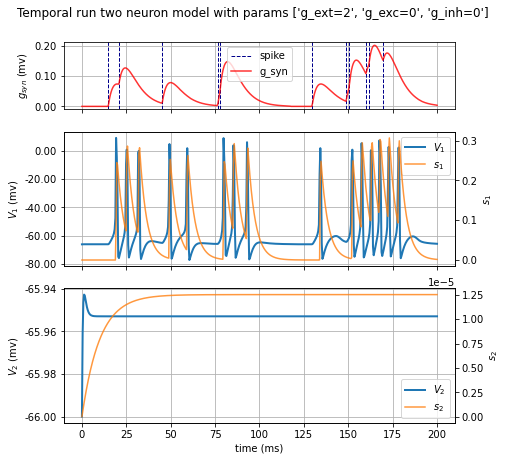

In [106]:
fig, ax = plt.subplots(3,1, figsize=(7,7), sharex=True, gridspec_kw={ 'height_ratios': [1, 2, 2],
                                                         'wspace':0, 
                                                         'hspace':0.2 })
#fig.subplots_adjust(hspace=5)

# Plot neuron 2 response
l3, = ax[2].plot(time_span, run[:,1], c='tab:blue', label='$V_2$', lw=2.0)
ax11 = ax[2].twinx()
ax11.set(ylabel='$s_2$')
l4, = ax11.plot(time_span, run[:,5], c='tab:orange', label='$s_2$', alpha=0.8)

lines = [l3,l4]
ax[2].legend(lines, [l.get_label() for l in lines])

#title=f"Temporal run of the neuron with synaptic excitation with {spikes.shape[0]} spikes"
ax[2].set(xlabel="time (ms)",
       ylabel="$V_{2}$ (mv)",
       )
ax[2].grid()

# Plot spike lines
for t in spikes:
    l1 = ax[0].axvline(x=t, color='darkblue', linestyle='dashed', linewidth=1, label='spike')

# Create synaptic excitation
results = np.zeros(time_span.shape[0])
for it, t in enumerate(time_span):
    results[it] = (opt_gsyn(t, spikes))

# And plot it in secondary axe
l2, = ax[0].plot(time_span,results, c='r', alpha=0.8, label='g_syn')

lines = [l1,l2]
ax[0].legend(lines, [l.get_label() for l in lines])

ax[0].set(ylabel="$g_{syn}$ (mv)",
       )
ax[0].grid()


# Plot neuron 1 response
l3, = ax[1].plot(time_span, run[:,0], c='tab:blue', label='$V_1$', lw=2.0)
ax11 = ax[1].twinx()
ax11.set(ylabel='$s_1$')
l4, = ax11.plot(time_span, run[:,4], c='tab:orange', label='$s_1$', alpha=0.8)

lines = [l3,l4]
ax[1].legend(lines, [l.get_label() for l in lines])

#title=f"Temporal run of the neuron with synaptic excitation with {spikes.shape[0]} spikes"
ax[1].set(
       ylabel="$V_{1}$ (mv)",
       )
ax[1].grid()

for a in ax:
    a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 


pars = [f'{name}={params[name]}' for name in ['g_ext', 'g_exc', 'g_inh']]
fig.suptitle(f'Temporal run two neuron model with params {pars}', y=0.95)

fig.tight_layout()
fig.show()

In [108]:
d, n = 200, 500
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

<ipython-input-109-6efc11d14c88>:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


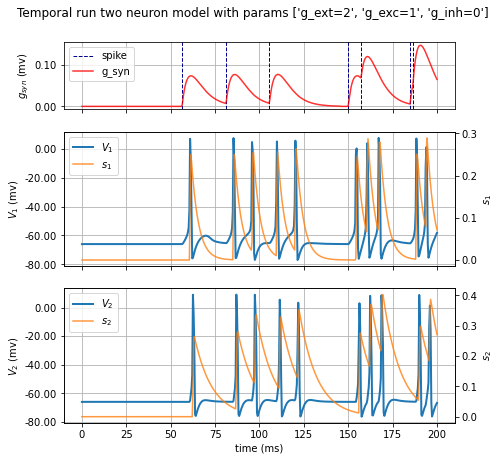

In [109]:
fig, ax = plt.subplots(3,1, figsize=(7,7), sharex=True, gridspec_kw={ 'height_ratios': [1, 2, 2],
                                                         'wspace':0, 
                                                         'hspace':0.2 })
#fig.subplots_adjust(hspace=5)

# Plot neuron 2 response
l3, = ax[2].plot(time_span, run[:,1], c='tab:blue', label='$V_2$', lw=2.0)
ax11 = ax[2].twinx()
ax11.set(ylabel='$s_2$')
l4, = ax11.plot(time_span, run[:,5], c='tab:orange', label='$s_2$', alpha=0.8)

lines = [l3,l4]
ax[2].legend(lines, [l.get_label() for l in lines])

#title=f"Temporal run of the neuron with synaptic excitation with {spikes.shape[0]} spikes"
ax[2].set(xlabel="time (ms)",
       ylabel="$V_{2}$ (mv)",
       )
ax[2].grid()

# Plot spike lines
for t in spikes:
    l1 = ax[0].axvline(x=t, color='darkblue', linestyle='dashed', linewidth=1, label='spike')

# Create synaptic excitation
results = np.zeros(time_span.shape[0])
for it, t in enumerate(time_span):
    results[it] = (opt_gsyn(t, spikes))

# And plot it in secondary axe
l2, = ax[0].plot(time_span,results, c='r', alpha=0.8, label='g_syn')

lines = [l1,l2]
ax[0].legend(lines, [l.get_label() for l in lines])

ax[0].set(ylabel="$g_{syn}$ (mv)",
       )
ax[0].grid()


# Plot neuron 1 response
l3, = ax[1].plot(time_span, run[:,0], c='tab:blue', label='$V_1$', lw=2.0)
ax11 = ax[1].twinx()
ax11.set(ylabel='$s_1$')
l4, = ax11.plot(time_span, run[:,4], c='tab:orange', label='$s_1$', alpha=0.8)

lines = [l3,l4]
ax[1].legend(lines, [l.get_label() for l in lines])

#title=f"Temporal run of the neuron with synaptic excitation with {spikes.shape[0]} spikes"
ax[1].set(
       ylabel="$V_{1}$ (mv)",
       )
ax[1].grid()

for a in ax:
    a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 


pars = [f'{name}={params[name]}' for name in ['g_ext', 'g_exc', 'g_inh']]
fig.suptitle(f'Temporal run two neuron model with params {pars}', y=0.95)

fig.tight_layout()
fig.show()

In [112]:
d, n = 200, 500
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 2}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

<ipython-input-113-6efc11d14c88>:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


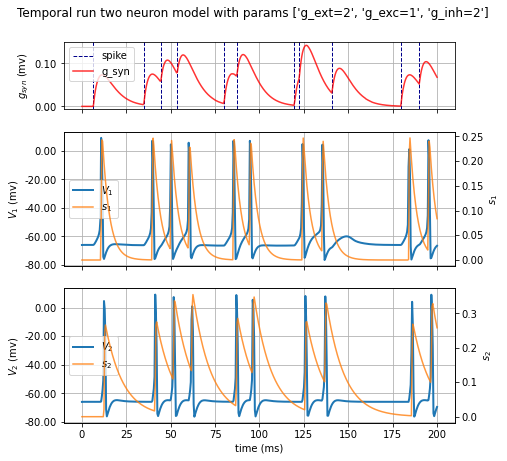

In [113]:
fig, ax = plt.subplots(3,1, figsize=(7,7), sharex=True, gridspec_kw={ 'height_ratios': [1, 2, 2],
                                                         'wspace':0, 
                                                         'hspace':0.2 })
#fig.subplots_adjust(hspace=5)

# Plot neuron 2 response
l3, = ax[2].plot(time_span, run[:,1], c='tab:blue', label='$V_2$', lw=2.0)
ax11 = ax[2].twinx()
ax11.set(ylabel='$s_2$')
l4, = ax11.plot(time_span, run[:,5], c='tab:orange', label='$s_2$', alpha=0.8)

lines = [l3,l4]
ax[2].legend(lines, [l.get_label() for l in lines])

#title=f"Temporal run of the neuron with synaptic excitation with {spikes.shape[0]} spikes"
ax[2].set(xlabel="time (ms)",
       ylabel="$V_{2}$ (mv)",
       )
ax[2].grid()

# Plot spike lines
for t in spikes:
    l1 = ax[0].axvline(x=t, color='darkblue', linestyle='dashed', linewidth=1, label='spike')

# Create synaptic excitation
results = np.zeros(time_span.shape[0])
for it, t in enumerate(time_span):
    results[it] = (opt_gsyn(t, spikes))

# And plot it in secondary axe
l2, = ax[0].plot(time_span,results, c='r', alpha=0.8, label='g_syn')

lines = [l1,l2]
ax[0].legend(lines, [l.get_label() for l in lines])

ax[0].set(ylabel="$g_{syn}$ (mv)",
       )
ax[0].grid()


# Plot neuron 1 response
l3, = ax[1].plot(time_span, run[:,0], c='tab:blue', label='$V_1$', lw=2.0)
ax11 = ax[1].twinx()
ax11.set(ylabel='$s_1$')
l4, = ax11.plot(time_span, run[:,4], c='tab:orange', label='$s_1$', alpha=0.8)

lines = [l3,l4]
ax[1].legend(lines, [l.get_label() for l in lines])

#title=f"Temporal run of the neuron with synaptic excitation with {spikes.shape[0]} spikes"
ax[1].set(
       ylabel="$V_{1}$ (mv)",
       )
ax[1].grid()

for a in ax:
    a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 


pars = [f'{name}={params[name]}' for name in ['g_ext', 'g_exc', 'g_inh']]
fig.suptitle(f'Temporal run two neuron model with params {pars}', y=0.95)

fig.tight_layout()
fig.show()

### 4- Short Term synaptical Plasticity

Implementation of the STP model proposed by Tsodyks and Markram [1]

[1] Tsodyks, Misha; Pawelzik, Klaus and Markram, Henry (1998). Neural Networks with Dynamic Synapses. Neural Computation. 10(4): 821-835.


In [258]:
from math import trunc

def stp(X):
    x,u,s = X
    return np.array([(1-x)/taud,
                     -u/tauf,
                     -s/taus])

In [259]:
d, n, dt = 300, 3001, 0.1 # Preserve this numbers ALWAYS -> n=d*10+1
time_span = np.linspace(0,d,n)
results = np.zeros((3,n)) # x,u,s
results[0,0] = 1

# STD dominated Params
taud, tauf, taus = 750, 50, 20
af, A = 0.45, 1

spikes = spike_train(d, 30, dt)
c=[]
for it, t in enumerate(time_span[:-1]):
    if it in (spikes*10).astype(int):
        xm, um, sm = results[:,it-1]   # This will break if there is spike at 0
        un = um+af*(1-um)
        results[:,it] =  np.array([xm*(1-un),un,sm+A*un*xm])
        
    results[:,it+1] = results[:,it] + stp(results[:,it])*dt # Crappy euler integration

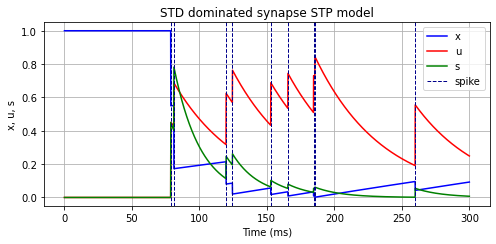

In [248]:
fig, ax = plt.subplots(1, figsize=(7,3.5))

l1, = ax.plot(time_span, results[0,:], c='b', label='x')
l2, = ax.plot(time_span, results[1,:], c='r', label='u')
l3, = ax.plot(time_span, results[2,:], c='g', label='s')

# Plot spike lines
for t in spikes:
    l4 = ax.axvline(x=t, color='darkblue', linestyle='dashed', linewidth=1, label='spike')

ax.set(title=f"STD dominated synapse STP model",
       xlabel="Time (ms)",
   ylabel="x, u, s",
   )
ax.grid()

lines = [l1,l2,l3,l4]
ax.legend(lines, [l.get_label() for l in lines])

fig.tight_layout()
fig.show()

In [254]:
d, n, dt = 300, 3001, 0.1 # Preserve this numbers ALWAYS -> n=d*10+1
time_span = np.linspace(0,d,n)
results = np.zeros((3,n)) # x,u,s
results[0,0] = 1

# STD dominated Params
taud, tauf, taus = 50, 750, 20
af, A = 0.15, 1

spikes = spike_train(d, 30, dt)
c=[]
for it, t in enumerate(time_span[:-1]):
    if it in (spikes*10).astype(int):
        xm, um, sm = results[:,it-1]   # This will break if there is spike at 0
        un = um+af*(1-um)
        results[:,it] =  np.array([xm*(1-un),un,sm+A*un*xm])
        
    results[:,it+1] = results[:,it] + stp(results[:,it])*dt

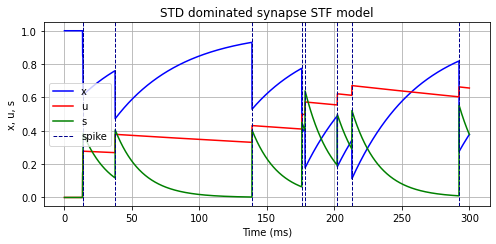

In [255]:
fig, ax = plt.subplots(1, figsize=(7,3.5))

l1, = ax.plot(time_span, results[0,:], c='b', label='x')
l2, = ax.plot(time_span, results[1,:], c='r', label='u')
l3, = ax.plot(time_span, results[2,:], c='g', label='s')

# Plot spike lines
for t in spikes:
    l4 = ax.axvline(x=t, color='darkblue', linestyle='dashed', linewidth=1, label='spike')

ax.set(title=f"STD dominated synapse STF model",
       xlabel="Time (ms)",
   ylabel="x, u, s",
   )
ax.grid()

lines = [l1,l2,l3,l4]
ax.legend(lines, [l.get_label() for l in lines])

fig.tight_layout()
fig.show()